# Setup

In [1]:
require 'torch'
require 'nn'
require 'nngraph'
require 'cunn'
require 'cutorch'
nngraph.setDebug(false)
-- load custom modules
require 'load'
require 'Sampler'
sampler = nn.Sampler():cuda()

In [2]:
-- get data
data = loadflipshift()
-- modify data
data.train = -data.train + 1
data.train = data.train:cuda()
train = data.train
masked_train = train:clone()
masked_train[{{},{1,2048}}] = 0

In [3]:
-- load saved cvae model
saved = torch.load('save/flipshift_CVAE_z1.t7')
model = saved.model
prior = saved.prior
encoder = saved.encoder
decoder = saved.decoder
-- load saved mlp model
saved = torch.load('save/flipshift_MLP.t7')
mlp = saved.model

# Image Reconstruction

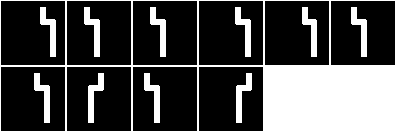

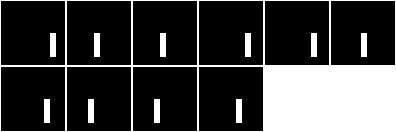

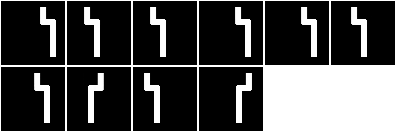

In [4]:
-- select images
N = 10
indices = torch.randperm(train:size(1)):long():split(N)
v = indices[1]
x_input = masked_train:index(1, v)
y_input = train:index(1, v)
-- cvae
pmu, plogv, mu, logv, recon = unpack(model:forward({x_input, y_input}))
-- original image
itorch.image(y_input:reshape(N, 1, 64, 64))
-- masked image
itorch.image(x_input:reshape(N, 1, 64, 64))
-- reconstructed image
itorch.image(recon:reshape(N, 1, 64, 64))

# Conditional Sampling

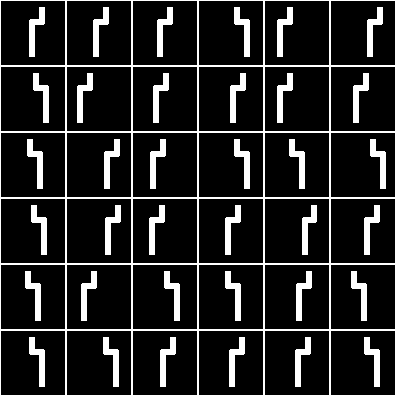

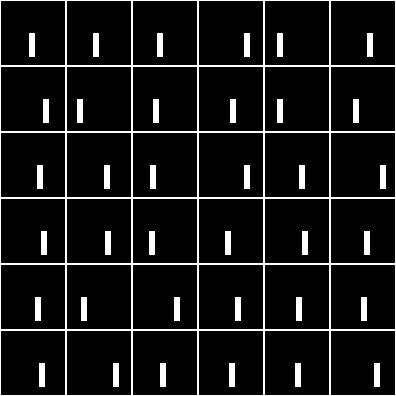

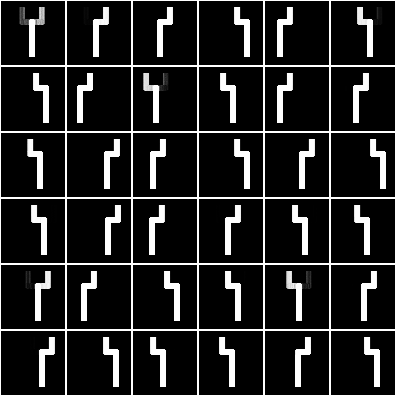

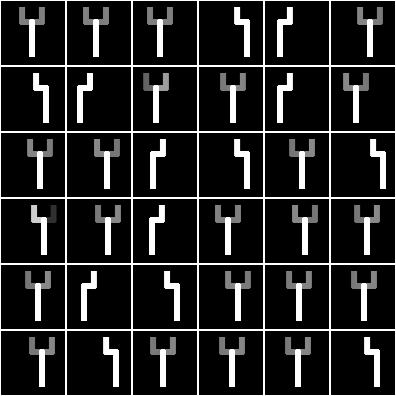

In [5]:
-- select images
N = 36
indices = torch.randperm(train:size(1)):long():split(N)
v = indices[1]
x_input = masked_train:index(1, v)
y_input = train:index(1, v)
-- original image
itorch.image(y_input:reshape(N, 1, 64, 64))
-- masked image
itorch.image(x_input:reshape(N, 1, 64, 64))
-- cvae
pmu, plogv = unpack(prior:forward(x_input))
code = sampler:forward({pmu, plogv})
recon = decoder:forward({x_input, code})
itorch.image(recon:reshape(N, 1, 64, 64))
-- mlp
mlp_recon = mlp:forward(x_input)
itorch.image(mlp_recon:reshape(N, 1, 64, 64))